In [2]:
import psutil
import humanize
import os
from IPython.display import display_html
import numpy as np 
import pandas as pd 
import os
print(os.listdir("../input"))
dataDirectory= "../input/logos-bk-kfc-mcdonald-starbucks-subway-none/logos_v3_mini/logos3" 
print(os.listdir(dataDirectory))

['keras-pretrained-models', 'logos-bk-kfc-mcdonald-starbucks-subway-none']
['test', 'train']


In [3]:
print(os.listdir("../input"))

['keras-pretrained-models', 'logos-bk-kfc-mcdonald-starbucks-subway-none']


In [4]:
!rm -r ~/.keras
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models

rm: cannot remove '/root/.keras': No such file or directory


# Dependicies

In [5]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline

# Paths to data

In [6]:
train_path = dataDirectory+'/train'
test_path  = dataDirectory+'/test'
print(os.listdir(train_path))
print(os.listdir(test_path))

['McDonalds', 'Starbucks', 'Other', 'Burger King', 'KFC', 'Subway']
['McDonalds', 'Starbucks', 'Other', 'Burger King', 'KFC', 'Subway']


In [7]:
train_datagen = ImageDataGenerator(validation_split=0.2) 


## Load data from directory

In [8]:
selectedClasses = ['Burger King', 'KFC','McDonalds','Other', 'Starbucks', 'Subway'] 

### Load images from the selected directories

In [9]:
batchSize=32
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='training') 
validation_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='validation')

test_generator = ImageDataGenerator().flow_from_directory(
    test_path, 
    target_size=(224,224), 
    classes=selectedClasses,
    shuffle= False,
    batch_size = batchSize)

Found 1393 images belonging to 6 classes.
Found 345 images belonging to 6 classes.
Found 560 images belonging to 6 classes.


### Number of samples of each class in all data generators

In [10]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
print ("") 

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(test_generator.classes).count(cls))



In train_generator 
Burger King :	 238
KFC :	 56
McDonalds :	 152
Other :	 660
Starbucks :	 187
Subway :	 100

In validation_generator 
Burger King :	 59
KFC :	 14
McDonalds :	 37
Other :	 165
Starbucks :	 46
Subway :	 24

In test_generator 
Burger King :	 153
KFC :	 20
McDonalds :	 96
Other :	 224
Starbucks :	 38
Subway :	 29


# Auxilary Functions for ploting images

In [11]:
def plots(ims, figsize = (22,22), rows=4, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
   
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')   

# Plot some train data

In [12]:
imgs, labels = train_generator.next()

#print(labels)

labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]

for ind in labelIndices:
    for labelName,labelIndex in train_generator.class_indices.items():
        if labelIndex == i:
            labelNames.append(labelName)

#labels

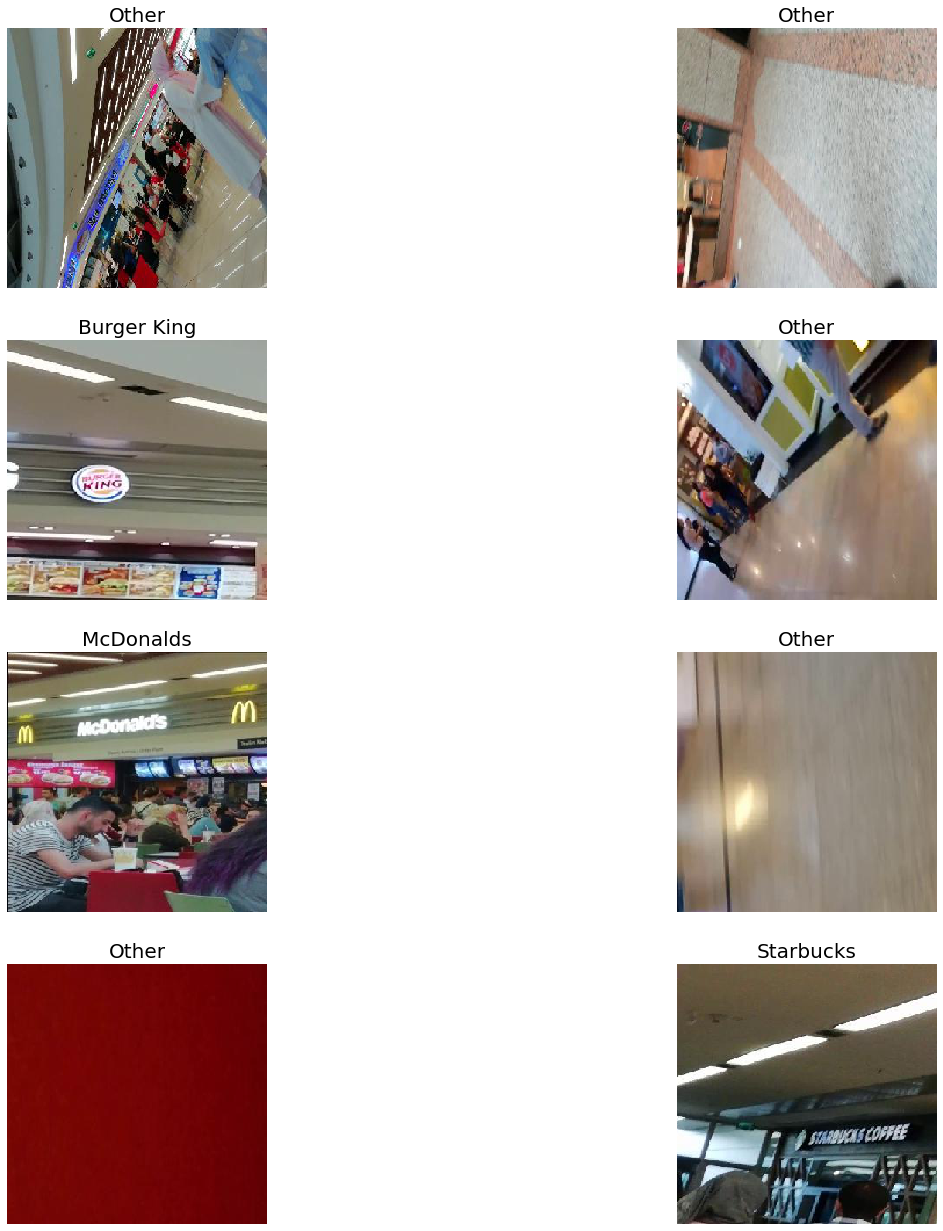

In [13]:
plots(imgs, rows=4, titles = labelNames, maxNum=8)

In [14]:
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x=Dense(128, activation='relu')(x)
x=Dropout(0.3)(x)
x=Dense(64, activation='relu')(x)
predictions = Dense(len(selectedClasses), activation='softmax')(x)
model = Model(base_model.input,predictions)
# model.summary()

In [15]:
modelName= "Inception"
filepath=modelName+"_bestweights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Compile the model 

In [16]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)

stepsPerEpoch:  44
validationSteps:  11


In [42]:
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs = 50,
    steps_per_epoch = len(train_generator),
    validation_steps= len(validation_generator),
    callbacks=callbacks_list)

Epoch 1/50
44/44 [==============================] - 6s 129ms/step - loss: 0.6327 - accuracy: 0.7265 - val_loss: 0.8087 - val_accuracy: 0.6957
Epoch 2/50
44/44 [==============================] - 5s 115ms/step - loss: 0.6227 - accuracy: 0.7387 - val_loss: 1.0746 - val_accuracy: 0.6754
Epoch 3/50
44/44 [==============================] - 5s 122ms/step - loss: 0.6443 - accuracy: 0.7322 - val_loss: 0.9799 - val_accuracy: 0.6957
Epoch 4/50
44/44 [==============================] - 5s 118ms/step - loss: 0.7110 - accuracy: 0.6978 - val_loss: 0.9910 - val_accuracy: 0.6551
Epoch 5/50
44/44 [==============================] - 5s 120ms/step - loss: 0.6368 - accuracy: 0.7401 - val_loss: 1.0029 - val_accuracy: 0.6493
Epoch 6/50
44/44 [==============================] - 5s 114ms/step - loss: 0.6377 - accuracy: 0.7574 - val_loss: 0.8580 - val_accuracy: 0.6928
Epoch 7/50
44/44 [==============================] - 6s 128ms/step - loss: 0.5918 - accuracy: 0.7645 - val_loss: 1.0161 - val_accuracy: 0.6899
Epoch 

## Show Training History
We can plot the accuracy and loss values for each epoch using the history object as follows.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


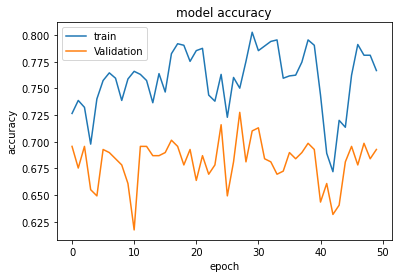

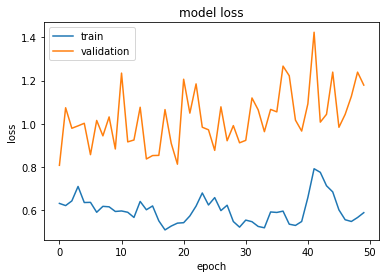

In [43]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Save the model and last weights

In [22]:
score = model.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("For validation data set; Loss: ",score[0]," Accuracy: ", score[1])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


For validation data set; Loss:  0.8330710530281067  Accuracy:  0.7043478488922119


In [23]:
score = model.evaluate_generator(test_generator, (test_generator.samples + (batchSize-1)) // batchSize)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  1.662027359008789  Accuracy:  0.6017857193946838


In [24]:
# test_generator.reset()
testStep = (test_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)
predictions = model.predict_generator(test_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  18


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


18/18 [==============================] - 3s 96ms/step


560

In [44]:
len(predictions)

560

In [45]:
predicted_class_indices=np.argmax(predictions,axis=1)
print(predicted_class_indices)
len(predicted_class_indices)

[0 2 0 2 0 4 0 4 0 4 4 4 3 0 4 0 0 0 4 4 2 2 2 0 0 4 0 4 0 0 0 0 0 0 0 0 0
 0 0 4 4 0 4 4 4 4 4 4 4 0 4 4 4 3 0 0 4 4 0 0 0 0 0 0 4 0 4 4 0 4 0 0 0 0
 4 0 0 0 0 0 4 4 4 4 0 4 4 0 0 0 0 4 0 4 4 4 0 0 4 0 0 4 4 4 4 0 0 0 0 4 4
 0 4 0 0 4 4 4 0 3 3 4 4 4 4 4 0 0 0 0 0 0 0 4 2 4 0 0 4 4 0 0 4 5 0 0 0 4
 0 0 0 0 0 4 4 4 4 4 4 4 3 4 4 4 4 4 4 3 4 4 4 4 4 3 3 3 3 3 3 3 4 3 3 0 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 2 4
 0 0 0 0 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 4 4 4
 0 0 4 4 3 4 3 4 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

560

In [46]:
labels = (test_generator.class_indices)
print(labels)

{'Burger King': 0, 'KFC': 1, 'McDonalds': 2, 'Other': 3, 'Starbucks': 4, 'Subway': 5}


In [47]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'Burger King', 1: 'KFC', 2: 'McDonalds', 3: 'Other', 4: 'Starbucks', 5: 'Subway'}


In [48]:
predictedLables= [labels[k] for k in predicted_class_indices]
print(predictedLables)
len(predictedLables)

['Burger King', 'McDonalds', 'Burger King', 'McDonalds', 'Burger King', 'Starbucks', 'Burger King', 'Starbucks', 'Burger King', 'Starbucks', 'Starbucks', 'Starbucks', 'Other', 'Burger King', 'Starbucks', 'Burger King', 'Burger King', 'Burger King', 'Starbucks', 'Starbucks', 'McDonalds', 'McDonalds', 'McDonalds', 'Burger King', 'Burger King', 'Starbucks', 'Burger King', 'Starbucks', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Starbucks', 'Starbucks', 'Burger King', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Starbucks', 'Burger King', 'Starbucks', 'Starbucks', 'Starbucks', 'Other', 'Burger King', 'Burger King', 'Starbucks', 'Starbucks', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Starbucks', 'Burger King', 'Starbucks', 'Starbucks', 'Burger King', 'Starbucks', 'Burger King', 'Burger King

560

In [49]:
actualLables= [labels[k] for k in test_generator.classes]
print(actualLables)
len(actualLables)

['Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger King', 'Burger K

560

In [50]:
accuracy_score(actualLables, predictedLables)

0.6017857142857143

In [51]:
matrix = confusion_matrix(actualLables, predictedLables)
print(labels)
matrix

{0: 'Burger King', 1: 'KFC', 2: 'McDonalds', 3: 'Other', 4: 'Starbucks', 5: 'Subway'}


array([[ 81,   0,   6,   4,  61,   1],
       [  0,   0,   0,   2,  18,   0],
       [ 52,   0,   1,  11,  32,   0],
       [  4,   0,   0, 218,   2,   0],
       [  2,   0,   0,   0,  36,   0],
       [  7,   0,   0,   2,  19,   1]])

In [52]:
print(classification_report(actualLables, predictedLables))

              precision    recall  f1-score   support

 Burger King       0.55      0.53      0.54       153
         KFC       0.00      0.00      0.00        20
   McDonalds       0.14      0.01      0.02        96
       Other       0.92      0.97      0.95       224
   Starbucks       0.21      0.95      0.35        38
      Subway       0.50      0.03      0.06        29

    accuracy                           0.60       560
   macro avg       0.39      0.42      0.32       560
weighted avg       0.58      0.60      0.56       560



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
recall_score( actualLables, predictedLables,average='weighted') 

0.6017857142857143

In [54]:
precision_score( actualLables, predictedLables,average='weighted') 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5844337474889384

## Plot the confusion matrix

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 81   0   6   4  61   1]
 [  0   0   0   2  18   0]
 [ 52   0   1  11  32   0]
 [  4   0   0 218   2   0]
 [  2   0   0   0  36   0]
 [  7   0   0   2  19   1]]


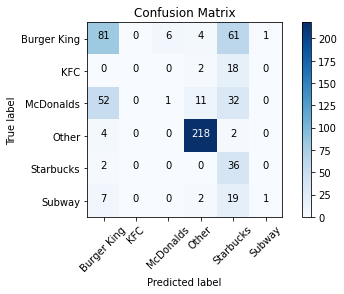

In [56]:
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix')

In [57]:
filenames=test_generator.filenames
directory= test_generator.directory
results=pd.DataFrame({"Directory":directory,
                      "Filename":filenames,
                      "Predictions":predictedLables,
                     "Actuals": actualLables })
results.to_csv("results.csv",index=False)

# Show some sample predictions with corresponding true labels


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


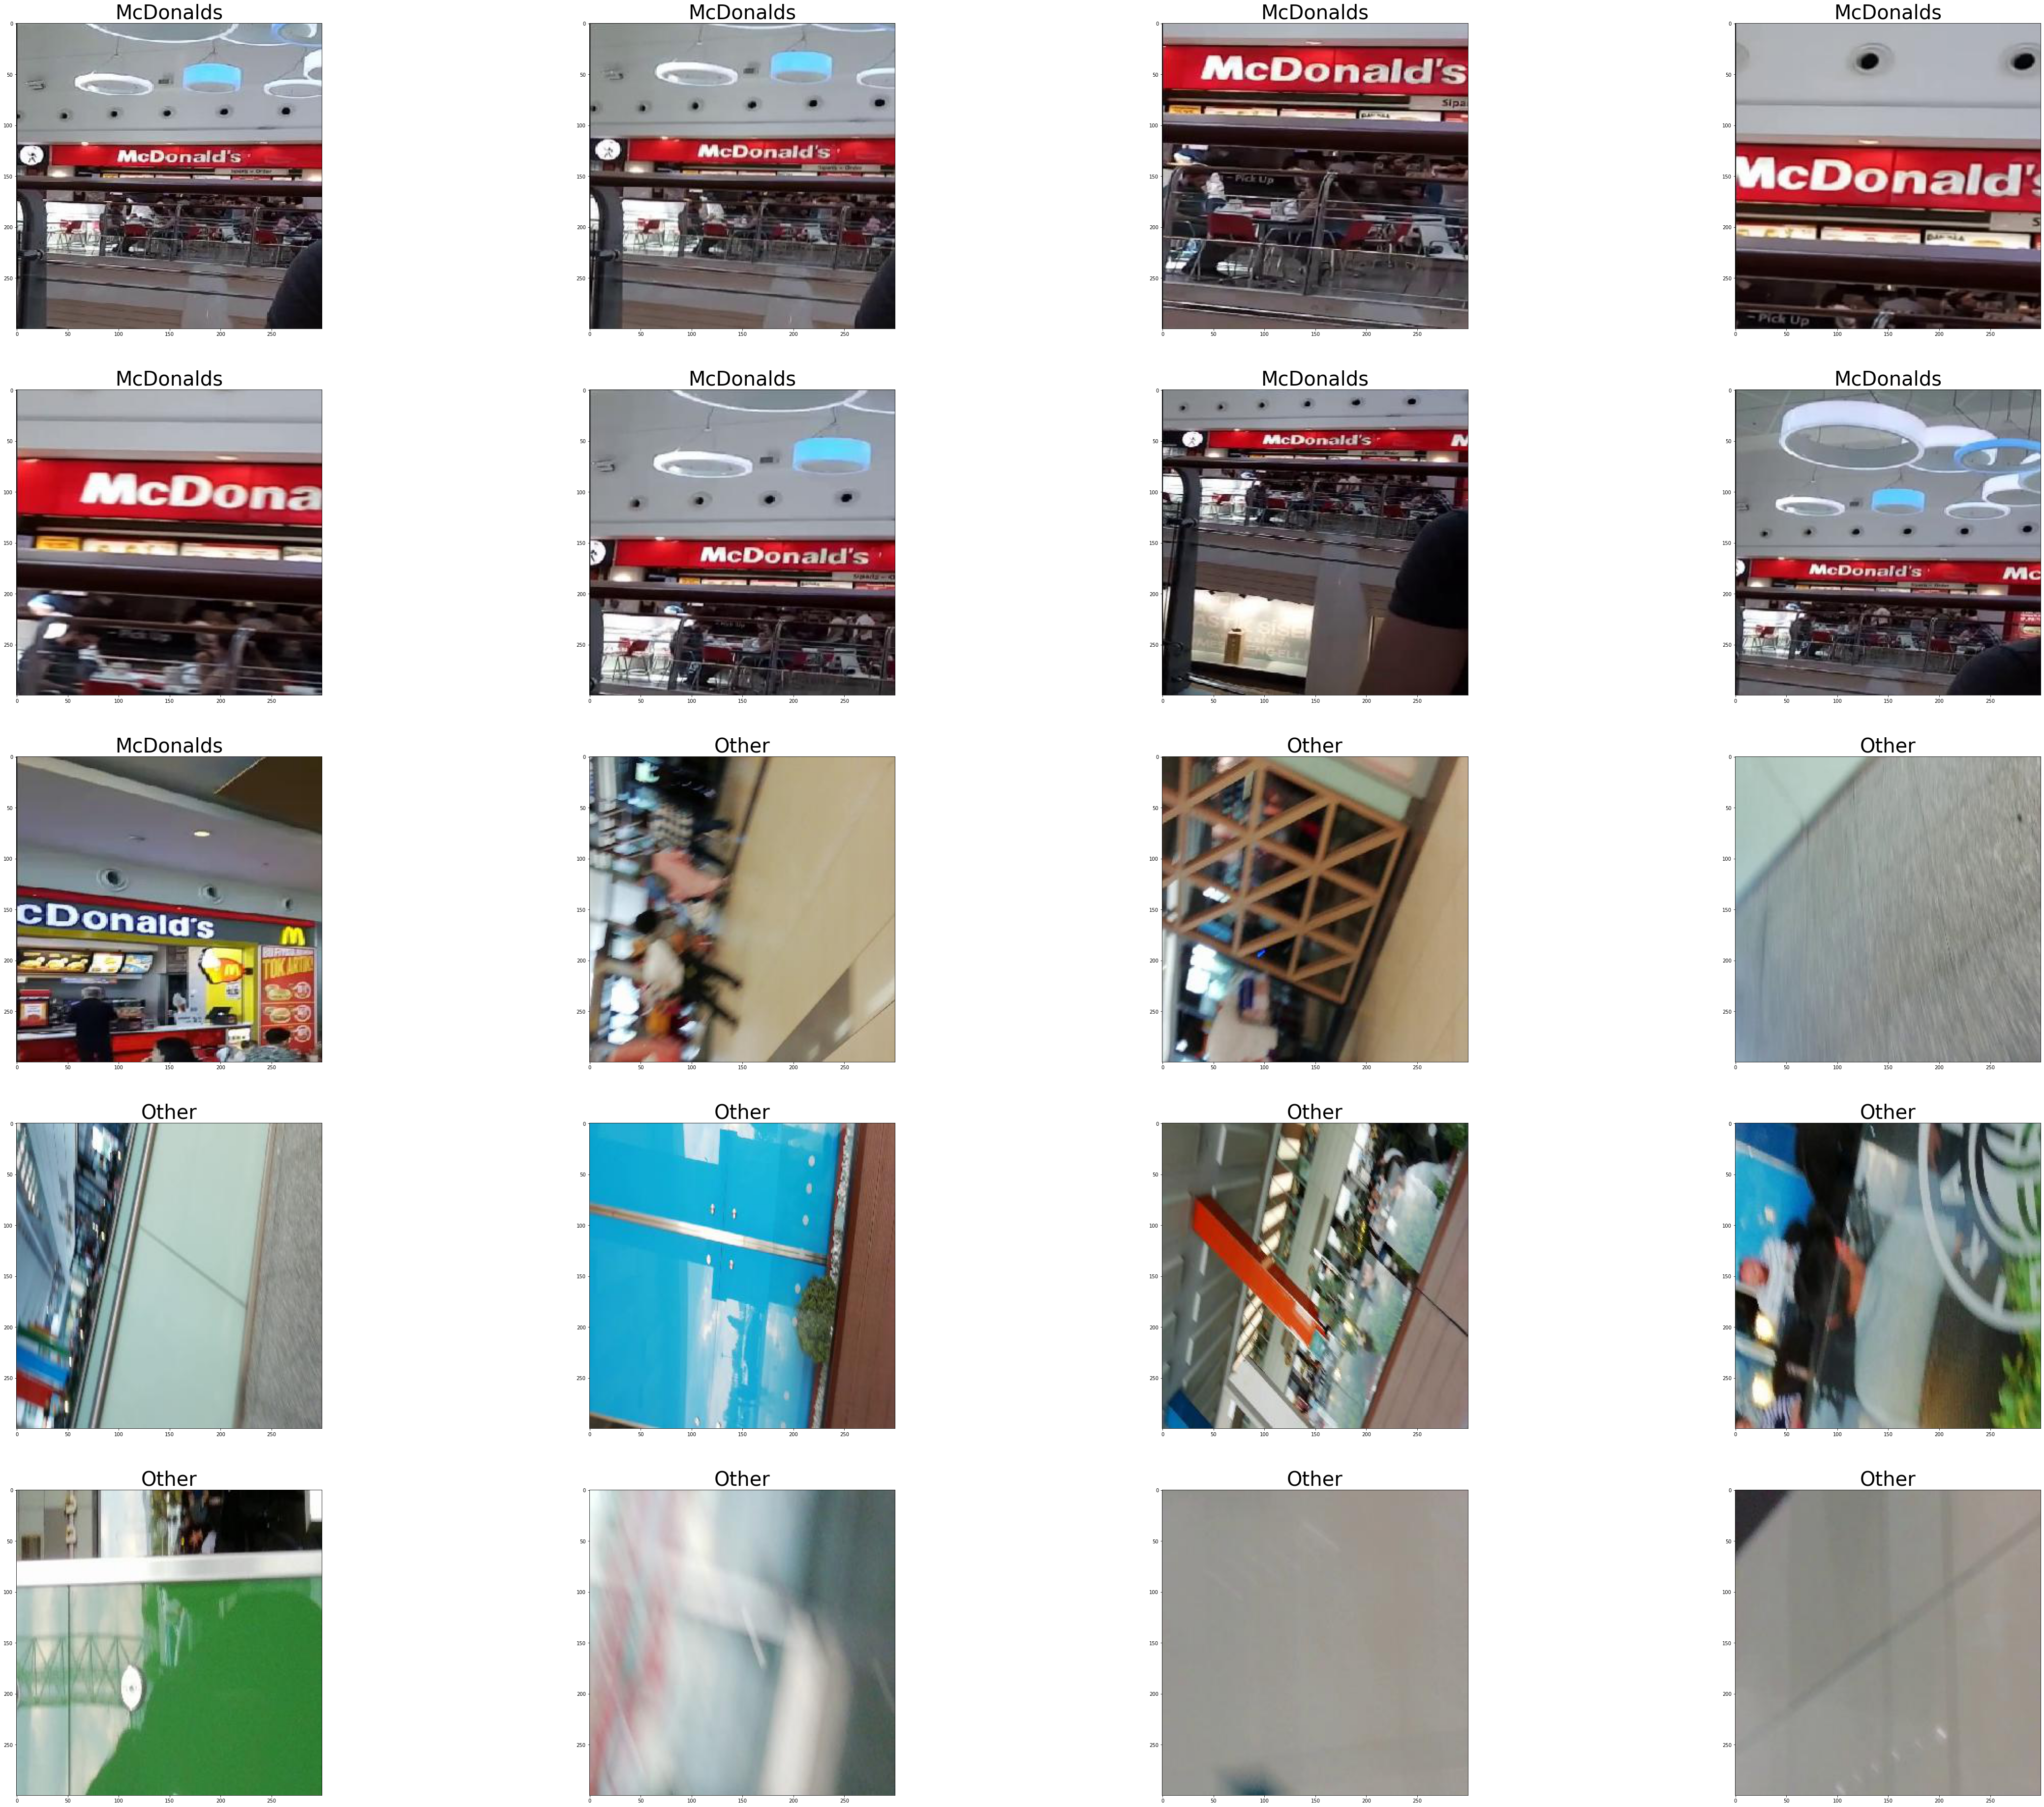

In [65]:
import matplotlib.image as mpimg
%matplotlib inline
res = results[260:280]
images = []
for img_path in "./"+res['Directory']+"/"+res['Filename']:
    images.append(mpimg.imread(img_path))
plt.figure(figsize=(80,80))
columns = 4
for i, image in enumerate(images):
    ax= plt.subplot(len(images) / columns + 1, columns, i + 1)
    ax.set_title(res['Prediction'].iloc[i], fontsize=40)
    plt.imshow(image)